### Importando bibliotecas e carregando a base de dados

In [33]:
import os
import tarfile
import urllib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from zlib import crc32
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
import seaborn as sns

In [2]:
TYPE = "tgz"
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/refs/heads/master/"
HOUSING_PATH = os.path.join('dataset', 'housing')
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing." + TYPE
print(HOUSING_URL)

https://raw.githubusercontent.com/ageron/handson-ml2/refs/heads/master/datasets/housing/housing.tgz


In [3]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH, type=TYPE):
    os.makedirs(housing_path, exist_ok=True)
    if type == "tgz":
        download_path = os.path.join(housing_path, 'housing.tgz')
    elif type == "csv":
        download_path = os.path.join(housing_path, 'housing.csv')
    else:
        print("Tipo não encontrado")
        return
    urllib.request.urlretrieve(housing_url, download_path)
    if type == 'tgz':
        housing_tgz = tarfile.open(download_path)
        housing_tgz.extractall(path=housing_path)
        housing_tgz.close()


In [4]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [5]:
fetch_housing_data()

### Primeiras visualizações

In [6]:
df = load_housing_data()
df.shape

(20640, 10)

In [7]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [9]:
df['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [10]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


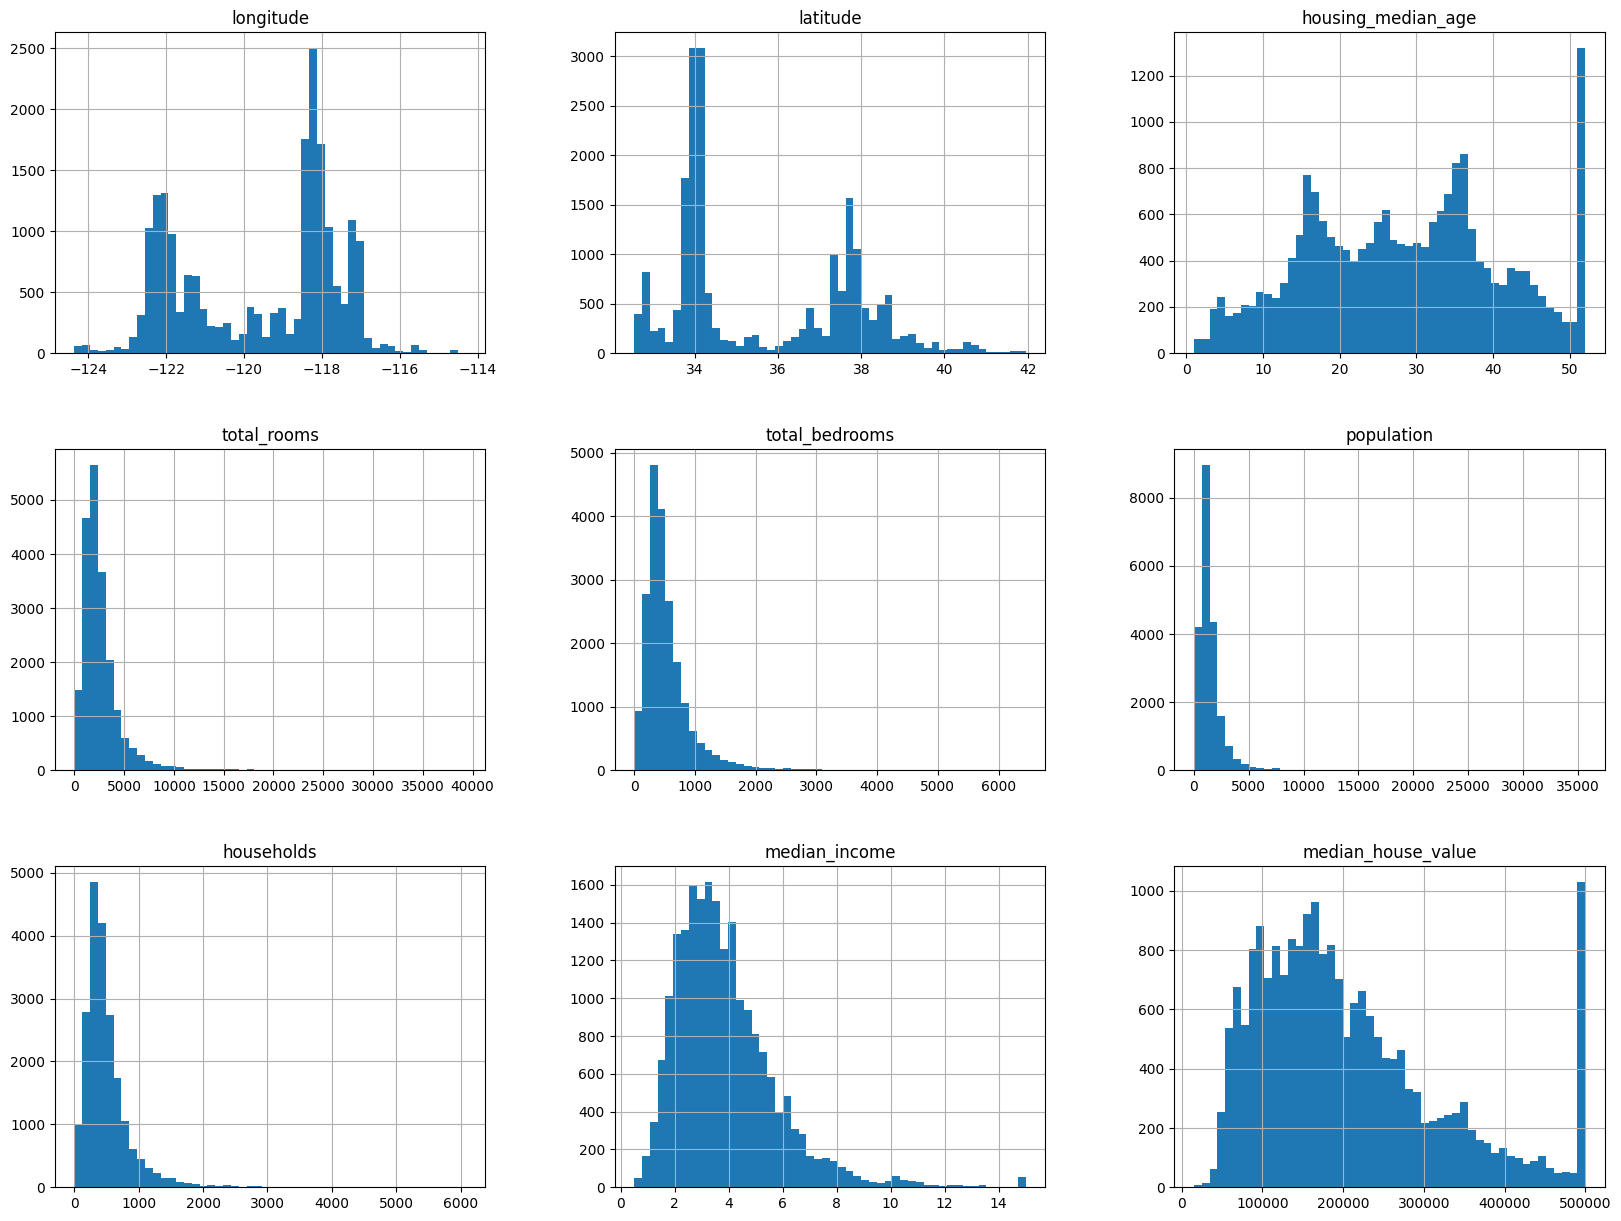

In [11]:
df.hist(bins=50, figsize=(20, 15))
plt.show()

### Separando a base de dados em treinamento e teste

#### Utilizando numpy

In [12]:
def split_train_test(dataframe, test_radio):
    np.random.seed(42)
    shuffled_indices = np.random.permutation(len(dataframe))
    test_size = int(len(dataframe) * test_radio)
    test_indices = shuffled_indices[:test_size]
    train_indices = shuffled_indices[test_size:]
    return dataframe.iloc[train_indices], dataframe.iloc[test_indices]

In [13]:
train_set, test_set = split_train_test(df, 0.2)

In [14]:
len(train_set)

16512

In [15]:
len(test_set)

4128

#### Utilizando id

In [16]:
def test_set_check(identifier, test_radio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_radio * 2**32

In [17]:
def split_train_test_by_id(dataframe, test_radio, id_column):
    ids = dataframe[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_radio))
    return dataframe.loc[~in_test_set], dataframe.loc[in_test_set]

In [18]:
df_with_id = df.reset_index()
df_with_id = df_with_id.rename(columns={'index': 'id'})

In [19]:
train_set, test_set = split_train_test_by_id(df_with_id, 0.2, "id") 

Criando um id através de caracteristicas

In [20]:
df_with_id['id_2'] = df['longitude'] * 1000 + df['latitude']
df_with_id.head()

,id,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id_2
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,-122192.12
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,-122182.14
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,-122202.15
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,-122212.15
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,-122212.15


In [21]:
# train_set_2, test_set_2 = split_train_test_by_id(df_with_id, 0.2, 'id_2')

#### Estratificando a amostra

##### Categorizando median_income

In [22]:
df['income_cat'] = pd.cut(df['median_income'],
                          bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                          labels=[1, 2, 3, 4, 5])

<Axes: >

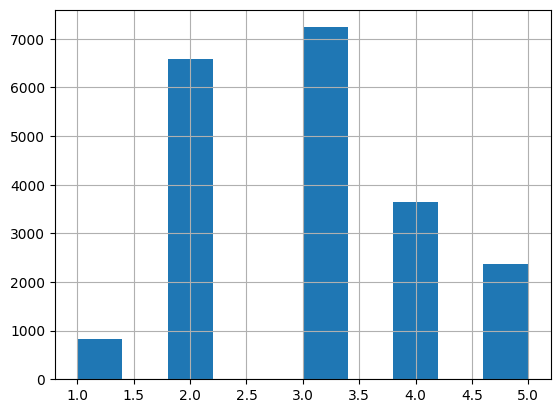

In [23]:
df['income_cat'].hist()

In [24]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df['income_cat']):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [25]:
df['income_cat'].value_counts() / len(df['income_cat'])

income_cat
3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: count, dtype: float64

In [26]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

##### Utilizando scikit-learn

In [27]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42, shuffle=True, stratify=df['income_cat'])

In [28]:
test_set['income_cat'].value_counts() / len(test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [29]:
strat_test_set.shape, test_set.shape

((4128, 11), (4128, 11))

Removendo o atributo income_cat

In [30]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

### Exploração e visualização dos dados

In [32]:
copy = strat_train_set.copy()

<Axes: xlabel='longitude', ylabel='latitude'>

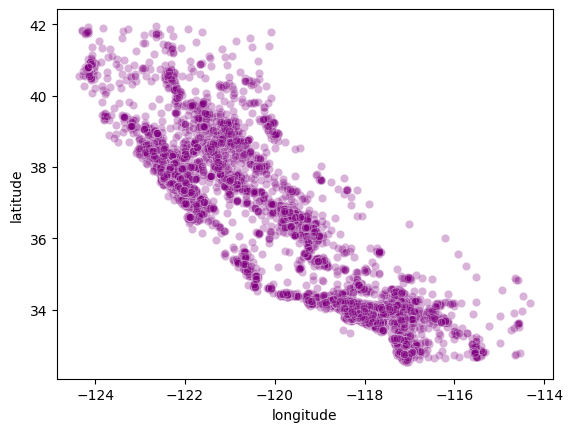

In [44]:
sns.scatterplot(data=copy, x='longitude', y='latitude', alpha=0.3, color='purple')